Y-DATA 2021/21<br/>
Large-scale ML HW1<br/>
Serge Tochilov

In [ ]:
# Checklist:
# AWS emr-5.29.0
# MASTER r5d.8xlarge 1x, no EBS
# CORE r5d.8xlarge 4x, no EBS
# Custom bootstrap action: s3://ydatazian/bootstrap.sh
# Allow ssh in master node security group

> There might be older Numpy versions installed behind the latest, clean that. Add libs missed from `emr-5.29.0` AWS image.

In [ ]:

! sudo pip-3.6 uninstall -y numpy
! sudo pip-3.6 uninstall -y numpy
! sudo pip-3.6 uninstall -y numpy
! sudo pip-3.6 install numpy

! sudo pip-3.6 install pypandoc
! sudo pip-3.6 install pyspark==2.4.8

Uninstalling numpy-1.19.5:
  Successfully uninstalled numpy-1.19.5
You are using pip version 9.0.3, however version 21.1.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Cannot uninstall requirement numpy, not installed
You are using pip version 9.0.3, however version 21.1.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Cannot uninstall requirement numpy, not installed
You are using pip version 9.0.3, however version 21.1.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Using cached https://files.pythonhosted.org/packages/45/b2/6c7545bb7a38754d63048c7696804a0d947328125d81bf12beaa692c3ae3/numpy-1.19.5-cp36-cp36m-manylinux1_x86_64.whl
You are using pip version 9.0.3, however version 21.1.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.3, however version 21.1.2 is available.
You should cons

In [ ]:
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt

# SparkSession

https://spark.apache.org/docs/2.4.4/api/python/pyspark.html

https://spark.apache.org/docs/2.4.4/api/python/pyspark.sql.html

In [ ]:
import findspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from ydata_lsml import spark_utils

findspark.init()
sc = SparkContext("yarn", "My App", conf=spark_utils.get_spark_conf())
se = SparkSession(sc)
spark_utils.print_ui_links()

NameNode: http://ec2-44-230-208-59.us-west-2.compute.amazonaws.com:50070
YARN: http://ec2-44-230-208-59.us-west-2.compute.amazonaws.com:8088
Spark UI: http://ec2-44-230-208-59.us-west-2.compute.amazonaws.com:20888/proxy/application_1622905103362_0002


# Ephemeral local HDFS

In [ ]:
! hdfs dfs -df -h

Filesystem                                                  Size     Used  Available  Use%
hdfs://ip-172-31-46-152.us-west-2.compute.internal:8020  547.5 G  222.3 M    546.5 G    0%


In [ ]:
! hdfs dfs -ls /

Found 3 items
drwxrwxrwt   - hdfs hadoop          0 2021-06-05 14:58 /tmp
drwxr-xr-x   - hdfs hadoop          0 2021-06-05 14:58 /user
drwxr-xr-x   - hdfs hadoop          0 2021-06-05 14:58 /var


# Persistent S3

https://www.kaggle.com/c/outbrain-click-prediction/data

In [ ]:
! aws s3 ls s3://ydatazian

                           PRE week1/
2021-05-21 04:09:44       1874 bootstrap.sh
2021-05-13 21:20:22  176843889 clicks_test.parquet
2021-05-13 21:20:22  495815517 clicks_train.parquet
2021-05-13 21:21:58   34267065 documents_categories.parquet
2021-05-13 21:21:58  206455957 documents_entities.parquet
2021-05-13 21:21:58   23859965 documents_meta.parquet
2021-05-13 21:21:58  187410196 documents_topics.parquet
2021-05-13 21:21:58  734643471 events.parquet
2021-05-13 21:56:44 50764611872 page_views.parquet
2021-05-13 21:21:58  248421413 page_views_sample.parquet
2021-05-13 21:21:59    5116927 promoted_content.parquet
2021-05-13 21:21:58  273136709 sample_submission.csv


# Read directly from S3

In [ ]:
df = se.read.parquet("s3://ydatazian/page_views.parquet")
df.show(5)

+--------------+-----------+---------+--------+------------+--------------+
|          uuid|document_id|timestamp|platform|geo_location|traffic_source|
+--------------+-----------+---------+--------+------------+--------------+
|1fd5f051fba643|        120| 31905835|       1|          RS|             2|
|8557aa9004be3b|        120| 32053104|       1|       VN>44|             2|
|c351b277a358f0|        120| 54013023|       1|       KR>12|             1|
|8205775c5387f9|        120| 44196592|       1|       IN>16|             2|
|9cb0ccd8458371|        120| 65817371|       1|   US>CA>807|             2|
+--------------+-----------+---------+--------+------------+--------------+
only showing top 5 rows



# Register all tables for sql queries

In [ ]:
tables = ["clicks_test", "clicks_train", 
          "documents_categories", "documents_entities", "documents_meta", "documents_topics", 
          "events", "page_views", "page_views_sample", "promoted_content"]
for name in tqdm.tqdm(tables):
    df = se.read.parquet("s3://ydatazian/{}.parquet".format(name))
    df.registerTempTable(name)
    print(name)
    display(df.limit(3).toPandas())

  0%|          | 0/10 [00:00<?, ?it/s]

clicks_test


,display_id,ad_id
0,16874594,66758
1,16874594,150083
2,16874594,162754


clicks_train


,display_id,ad_id,clicked
0,1,42337,0
1,1,139684,0
2,1,144739,1


documents_categories


,document_id,category_id,confidence_level
0,1595802,1611,0.92
1,1595802,1610,0.07
2,1524246,1807,0.92


documents_entities


,document_id,entity_id,confidence_level
0,1524246,f9eec25663db4cd83183f5c805186f16,0.672865314504701
1,1524246,55ebcfbdaff1d6f60b3907151f38527a,0.399113728441297
2,1524246,839907a972930b17b125eb0247898412,0.392095749652966


documents_meta


,document_id,source_id,publisher_id,publish_time
0,1595802,1,603,2016-06-05 00:00:00
1,1524246,1,603,2016-05-26 11:00:00
2,1617787,1,603,2016-05-27 00:00:00


documents_topics


,document_id,topic_id,confidence_level
0,1595802,140,0.0731131601068925
1,1595802,16,0.0594164867373976
2,1595802,143,0.0454207537554526


events


,display_id,uuid,document_id,timestamp,platform,geo_location
0,1,cb8c55702adb93,379743,61,3,US>SC>519
1,2,79a85fa78311b9,1794259,81,2,US>CA>807
2,3,822932ce3d8757,1179111,182,2,US>MI>505


page_views


,uuid,document_id,timestamp,platform,geo_location,traffic_source
0,1fd5f051fba643,120,31905835,1,RS,2
1,8557aa9004be3b,120,32053104,1,VN>44,2
2,c351b277a358f0,120,54013023,1,KR>12,1


page_views_sample


,uuid,document_id,timestamp,platform,geo_location,traffic_source
0,1fd5f051fba643,120,31905835,1,RS,2
1,8557aa9004be3b,120,32053104,1,VN>44,2
2,c351b277a358f0,120,54013023,1,KR>12,1


promoted_content


,ad_id,document_id,campaign_id,advertiser_id
0,1,6614,1,7
1,2,471467,2,7
2,3,7692,3,7


# Simple SQL query

In [ ]:
%%time
df = se.sql(
"""
select 
    uuid, 
    count(1) as cnt
from page_views
group by uuid
""")
df.write.parquet("/count_per_user.parquet", mode='overwrite')

CPU times: user 58.5 ms, sys: 15.6 ms, total: 74.1 ms
Wall time: 8min 27s


In [ ]:
%%time
se.read.parquet("/count_per_user.parquet").show(5)

+--------------+---+
|          uuid|cnt|
+--------------+---+
|69a0927195c09e|  1|
|916d104e0c236d|  1|
|63dba7c280a635|  8|
|4d734fe22d203e|  8|
|b6b3ce2563ef84|  8|
+--------------+---+
only showing top 5 rows

CPU times: user 2.87 ms, sys: 606 µs, total: 3.48 ms
Wall time: 6.64 s


In [ ]:
! hdfs dfs -ls /

Found 4 items
drwxr-xr-x   - hadoop hadoop          0 2021-06-05 16:00 /count_per_user.parquet
drwxrwxrwt   - hdfs   hadoop          0 2021-06-05 14:58 /tmp
drwxr-xr-x   - hdfs   hadoop          0 2021-06-05 14:58 /user
drwxr-xr-x   - hdfs   hadoop          0 2021-06-05 14:58 /var


# The same in Python (10x slower)

In [ ]:
df = se.table("page_views")
print(df)

DataFrame[uuid: string, document_id: string, timestamp: string, platform: string, geo_location: string, traffic_source: string]


In [ ]:
rdd = df.rdd
print(rdd)
print(rdd.take(1))  # sent to driver (our Jupyter kernel)
print(rdd.take(1)[0].uuid)  # Python object

MapPartitionsRDD[41] at javaToPython at NativeMethodAccessorImpl.java:0
[Row(uuid='1fd5f051fba643', document_id='120', timestamp='31905835', platform='1', geo_location='RS', traffic_source='2')]
1fd5f051fba643


In [ ]:
%%time
! hdfs dfs -rm -r /count_per_user.pickle
se.table("page_views").rdd\
    .map(lambda x: (x.uuid, 1))\
    .reduceByKey(lambda x, y: x + y)\
    .saveAsPickleFile("/count_per_user.pickle")

rm: `/count_per_user.pickle': No such file or directory
CPU times: user 84.7 ms, sys: 47.4 ms, total: 132 ms
Wall time: 14min 39s


In [ ]:
%%time
sc.pickleFile("/count_per_user.pickle").take(5)

CPU times: user 4.58 ms, sys: 0 ns, total: 4.58 ms
Wall time: 273 ms


[('3c58d1e5492dca', 11),
 ('a12ae780183cdb', 30),
 ('1da02cb8987a6b', 3),
 ('69bf3a4dc14efa', 7),
 ('94c581628b3278', 6)]

In [ ]:
# and we can convert it back to Spark DataFrame
from pyspark.sql import Row
rdd_of_rows = sc.pickleFile("/count_per_user.pickle")\
    .map(lambda x: Row(uuid=x[0], cnt=x[1]))
df = se.createDataFrame(rdd_of_rows)
df.write.parquet("/count_per_user_converted.parquet", mode='overwrite')

In [ ]:
df = se.read.parquet("/count_per_user_converted.parquet")
df.printSchema()
df.show(5)

root
 |-- cnt: long (nullable = true)
 |-- uuid: string (nullable = true)

+---+--------------+
|cnt|          uuid|
+---+--------------+
|  3|ec1e1d69ca180d|
|  5|24727a458b42ec|
|  6|ce86c4017fe64e|
| 11|836c96b4247a66|
|  1|c3476e60057d80|
+---+--------------+
only showing top 5 rows



In [ ]:
! hdfs dfs -du -s -h "/*"

10.4 G  /count_per_user.parquet
19.1 G  /count_per_user.pickle
10.4 G  /count_per_user_converted.parquet
0  /tmp
220.5 M  /user
315  /var


# Collect data on the driver

In [ ]:
%%time
counts = se.read.parquet("/count_per_user_converted.parquet").rdd\
    .map(lambda x: x.cnt)\
    .collect()

CPU times: user 14.6 s, sys: 2.57 s, total: 17.2 s
Wall time: 1min 27s


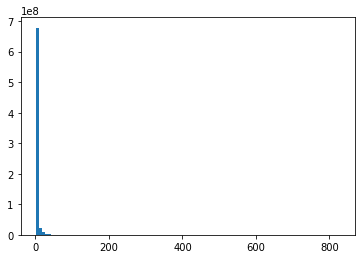

In [ ]:
_ = plt.hist(counts, bins=100)

# SQL + Python hybrid

In [ ]:
se.table("page_views").show(5)

+--------------+-----------+---------+--------+------------+--------------+
|          uuid|document_id|timestamp|platform|geo_location|traffic_source|
+--------------+-----------+---------+--------+------------+--------------+
|1fd5f051fba643|        120| 31905835|       1|          RS|             2|
|8557aa9004be3b|        120| 32053104|       1|       VN>44|             2|
|c351b277a358f0|        120| 54013023|       1|       KR>12|             1|
|8205775c5387f9|        120| 44196592|       1|       IN>16|             2|
|9cb0ccd8458371|        120| 65817371|       1|   US>CA>807|             2|
+--------------+-----------+---------+--------+------------+--------------+
only showing top 5 rows



In [ ]:
df = se.sql(
"""
select 
    uuid, 
    collect_list(struct(document_id, timestamp, platform, geo_location, traffic_source)) as views
from page_views
group by uuid
""")
df.printSchema()

root
 |-- uuid: string (nullable = true)
 |-- views: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- document_id: string (nullable = true)
 |    |    |-- timestamp: string (nullable = true)
 |    |    |-- platform: string (nullable = true)
 |    |    |-- geo_location: string (nullable = true)
 |    |    |-- traffic_source: string (nullable = true)



In [ ]:
%%time
! hdfs dfs -rm -r /platforms_per_user.pickle
from collections import defaultdict

def mapper(x):
    d = defaultdict(int)
    for row in x.views:
        d[row.platform] += 1
    return (x.uuid, d)

df.rdd.map(mapper).saveAsPickleFile("/platforms_per_user.pickle")

Deleted /platforms_per_user.pickle
CPU times: user 40.8 ms, sys: 29.9 ms, total: 70.8 ms
Wall time: 10min 27s


# The same in Python (5x slower)

In [ ]:
%%time
! hdfs dfs -rm -r /platforms_per_user2.pickle

def mapper(x):
    d = defaultdict(int)
    for row in x[1]:
        d[row.platform] += 1
    return (x[0], d)

(
    se
    .table("page_views")
    .rdd
    .groupBy(lambda x: x.uuid)
    .map(mapper)
    .saveAsPickleFile("/platforms_per_user2.pickle")
)

rm: `/platforms_per_user2.pickle': No such file or directory
CPU times: user 125 ms, sys: 86.1 ms, total: 211 ms
Wall time: 52min 8s


# HW1. Spark EDA

## Q1. Find 10 most visited `document_ids` in `page_views` log

In [ ]:
%%time
df = se.sql(
"""
    select
        document_id, count(*) as cnt
    from
        page_views
    group by
        document_id
    order by
        cnt desc
    limit 10
""")
df.printSchema()
display(df.toPandas())

root
 |-- document_id: string (nullable = true)
 |-- cnt: long (nullable = false)



,document_id,cnt
0,1179111,26688981
1,394689,10454691
2,2191,5044391
3,7054,4996916
4,38922,4930261
5,1154100,4610780
6,357569,4046253
7,1827718,3046274
8,234,2359994
9,467462,2328065


CPU times: user 20.7 ms, sys: 4.98 ms, total: 25.7 ms
Wall time: 1min 19s


## Q2. Find 10 most visited `topic_ids` in `page_views` (use also `documents_topics` table)

In [ ]:
%%time
df = se.sql(
"""
    select
        topic_id, count(*) as cnt
    from
        page_views
    inner join
        documents_topics
    on
        page_views.document_id = documents_topics.document_id
    group by
        topic_id
    order by
        cnt desc
    limit 10
""")
df.printSchema()
display(df.toPandas())

root
 |-- topic_id: string (nullable = true)
 |-- cnt: long (nullable = false)



,topic_id,cnt
0,16,226580657
1,140,175020525
2,20,171010359
3,143,153101583
4,136,137553975
5,216,109567943
6,8,105683622
7,160,99645579
8,181,98421838
9,97,90551102


CPU times: user 38.6 ms, sys: 6.57 ms, total: 45.1 ms
Wall time: 4min 2s


## Q3. Find out how many users have at least two different `traffic_sources` in their `page_views` log

In [ ]:
%%time
df = se.sql(
"""
    select
        count(*) as uuid_2_src
    from (
        select
            uuid, count(*) as cnt 
        from (
            select
                uuid, traffic_source, count(*) as cnt_ut
            from
                page_views
            group by
                traffic_source, uuid
            order by
                cnt_ut desc)
        group by
            uuid
        having
            cnt > 1
        order by
            cnt desc)
""")
df.printSchema()

root
 |-- uuid_2_src: long (nullable = false)

CPU times: user 2.21 ms, sys: 13 µs, total: 2.22 ms
Wall time: 74.2 ms


In [ ]:
%%time
display(df.toPandas())

,uuid_2_src
0,93342305


CPU times: user 269 ms, sys: 70.2 ms, total: 339 ms
Wall time: 37min 49s


> $\sim93.3$ mln users have at least two different `traffic_source` in their `page_views` log.